$(0,1)$ may occur for instances with $-204 < x1 < -8, 97 < x2$
- Differences: $-200 < x1 < -71, 60 < x2$ (34 instances)
- R: $x1 < -40$
    - CF: $x1≥-8 \rightarrow (1,1)$
    - RL: $x1 > -200, x2 > 101$
        - CF: $x1≤-204 \rightarrow (0,0)$
        - CF: $x2≤97 \rightarrow (0,0)$

$(1,0)$ may occur for instances with $-9 < x1 < 151, -109 < x2 < 98$
- Differences: $-36 < x1 < 150, -88 < 77$ (64 instances)
- R: $x1 > 23$
    - CF: $x1≤-9 \rightarrow (0,0)$
    - RL: $x1 < 150, 47 < x2 < 77$
        - CF: $x1≥151 \rightarrow (1,1)$
        - CF: $x2≤-109 \rightarrow (1,1)$
        - CF: $x2≥98 \rightarrow (1,1)$

In [13]:
import pandas as pd
import numpy as np
import scipy as sp
import pickle
import cloudpickle
import matplotlib.pyplot as plt
from IPython.display import display
import shap
from comparers import ModelComparer, plot_decision_boundary
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances
from clustering import make_clustering, plot_dendrogram
from tasks.running_example import make_task
shap.initjs()

In [2]:
with open('shap.expl', 'rb') as f:
    explanations, indices_nonfinite_predictions, explanations_nonfinite, comparer = \
        pickle.load(f)

In [2]:
clf_a, clf_b, X, y, feature_names = make_task()

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

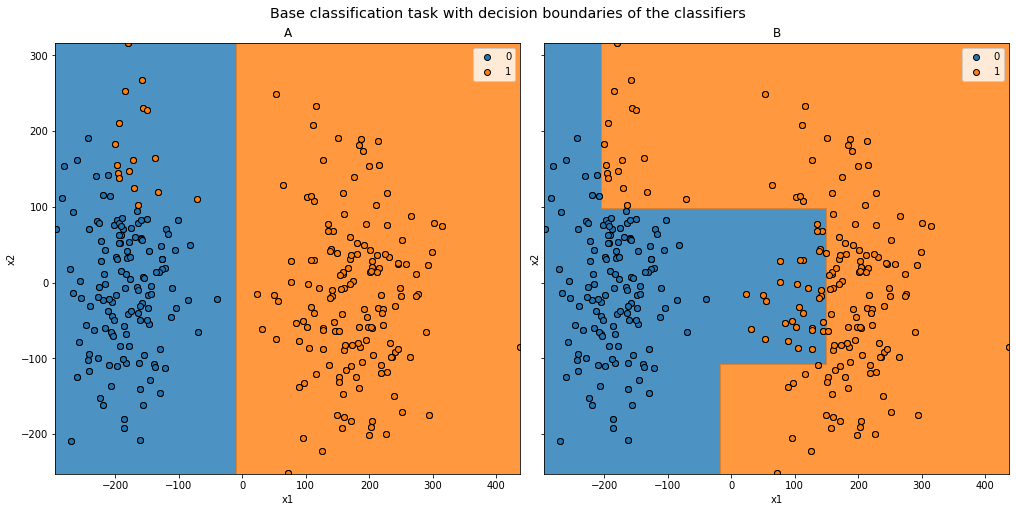

In [4]:
comparer.plot_individual_clf_decision_boundaries(X, y_true=y, kind='label')

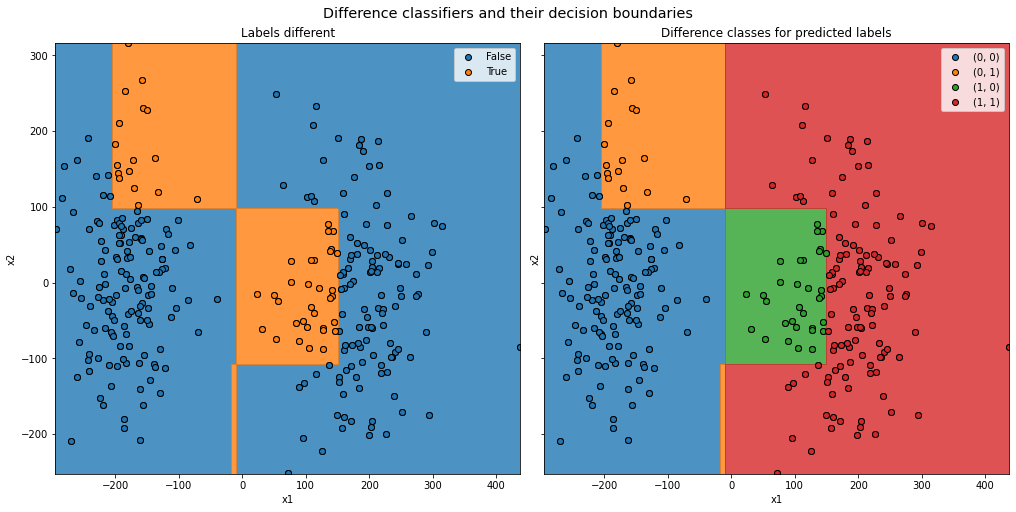

In [5]:
comparer.plot_decision_boundaries(X)

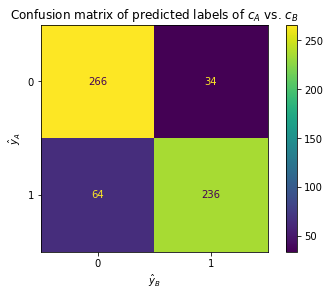

In [6]:
comparer.plot_confusion_matrix(X)

In [7]:
%%time
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])
explanations, indices_nonfinite_predictions, explanations_nonfinite = \
    generate_shap_explanations(comparer, X, masker=masker,
                               explanation_types=['indiv', 'indiv_diff', 'mclass_diff'],
                               space_types=['labels'])
with open('shap.expl', 'wb') as f:
    pickle.dump((explanations, indices_nonfinite_predictions, explanations_nonfinite, comparer),
                f, pickle.HIGHEST_PROTOCOL)

Exact explainer: 601it [00:38, 15.78it/s]                          


CPU times: user 37.4 s, sys: 1.41 s, total: 38.8 s
Wall time: 49.4 s


As we can see, no instances had infinite log-space predictions and no instances had infinite SHAP values:

In [8]:
explanations.shape, indices_nonfinite_predictions.shape, explanations_nonfinite.shape

((600, 2), (0,), (0,))

# Traditional SHAP Explanations

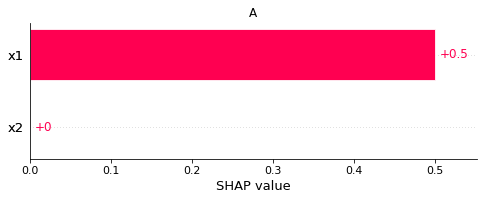

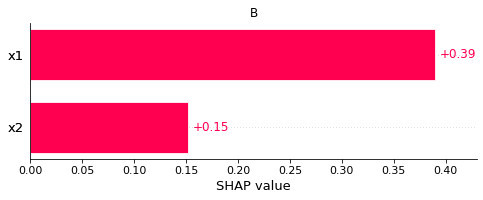

In [3]:
feature_order, feature_importance = calc_feature_order(explanations.indiv.labels.A[:, :, 1])
plot_feature_importance_bar(feature_importance, 'A', feature_order)
feature_order, feature_importance = calc_feature_order(explanations.indiv.labels.B[:, :, 1])
plot_feature_importance_bar(feature_importance, 'B', feature_order)

In [4]:
feature_order, _ = calc_feature_order(explanations.indiv.labels[:, :, 1])

In [5]:
node, Z = make_clustering(comparer, explanations.indiv.labels[:, :, 1])

root
(0, 0)    266
(1, 1)    236
(1, 0)     64
(0, 1)     34
dtype: int64


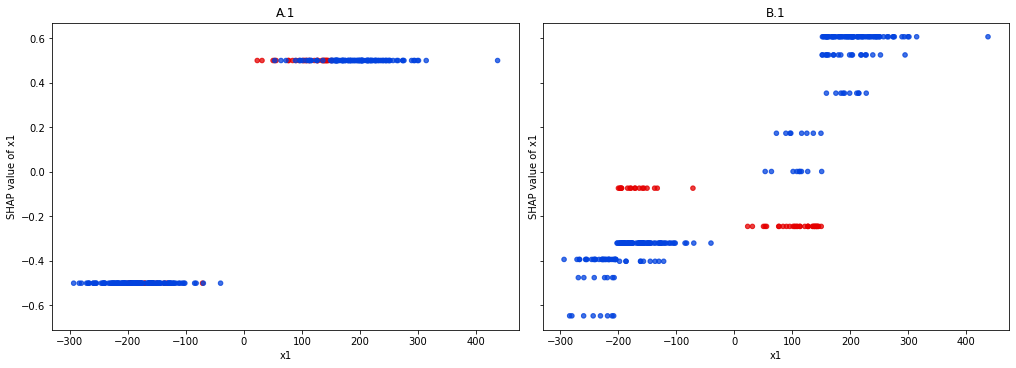

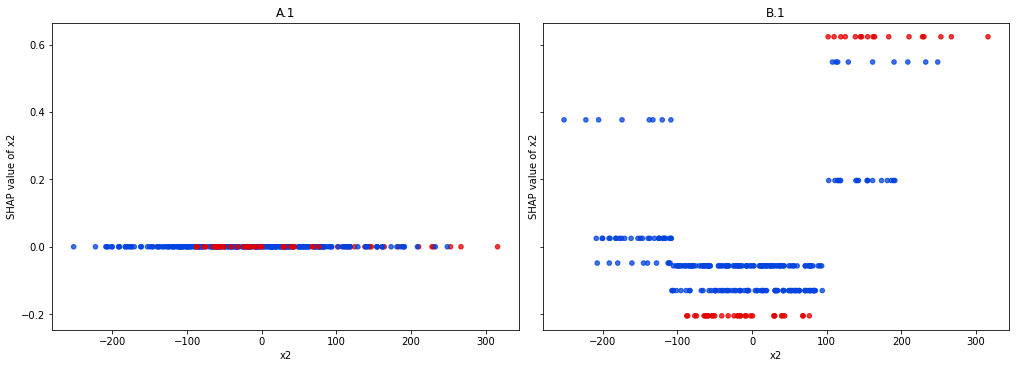

In [7]:
for feature in feature_order:
    node.plot_feature(feature, alpha=0.5)

# Difference Classifier SHAP Explanations

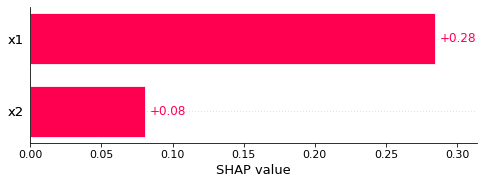

In [8]:
feature_order, feature_importances = calc_feature_order(explanations.mclass_diff.labels)
plot_feature_importance_bar(feature_importances)

In [10]:
global_feature_order = feature_order

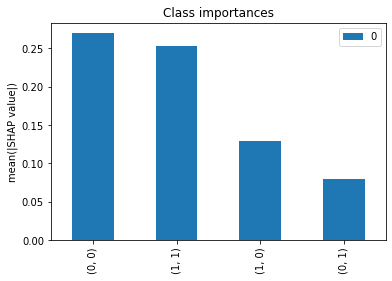

In [14]:
class_order, class_importances = calc_class_order(explanations.mclass_diff.labels)
plot_class_importances(class_importances, class_order, explanations.mclass_diff.output_names)

## Clustering of Class $(0,1)$ SHAP Values

In [17]:
node, Z = make_clustering(comparer, explanations.mclass_diff.labels, '(0, 1)', ['(0, 0)', '(0, 1)', '(1, 1)'])

root
(0, 0)    266
(1, 1)    236
(1, 0)     64
(0, 1)     34
dtype: int64


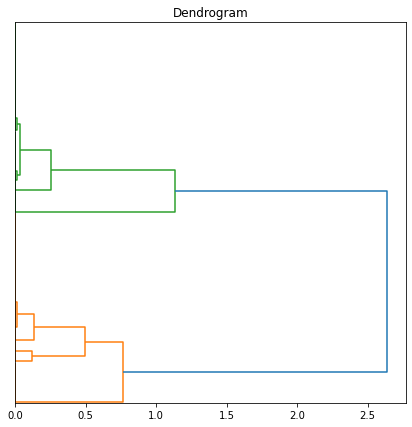

In [18]:
plot_dendrogram(Z)

### Root Node

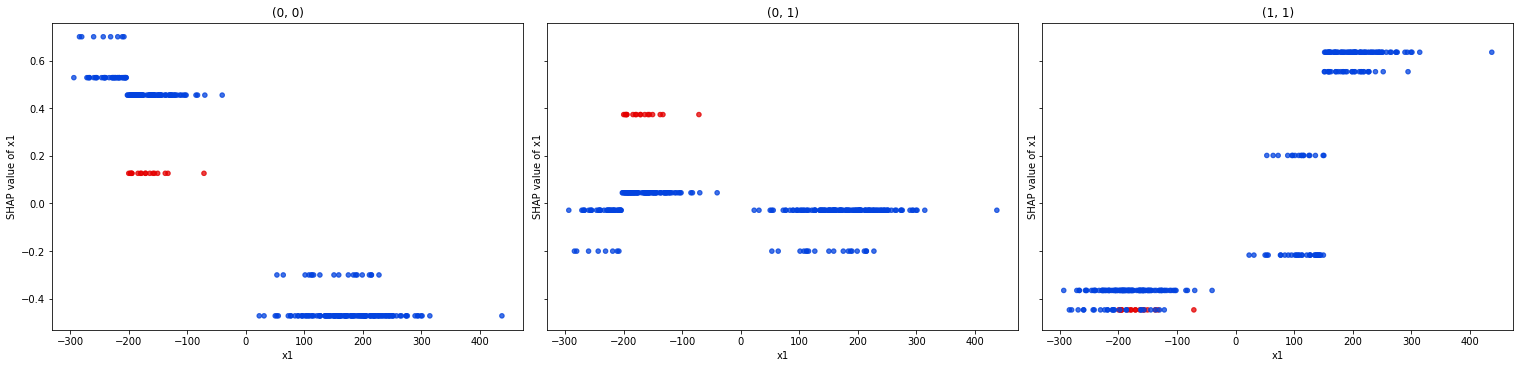

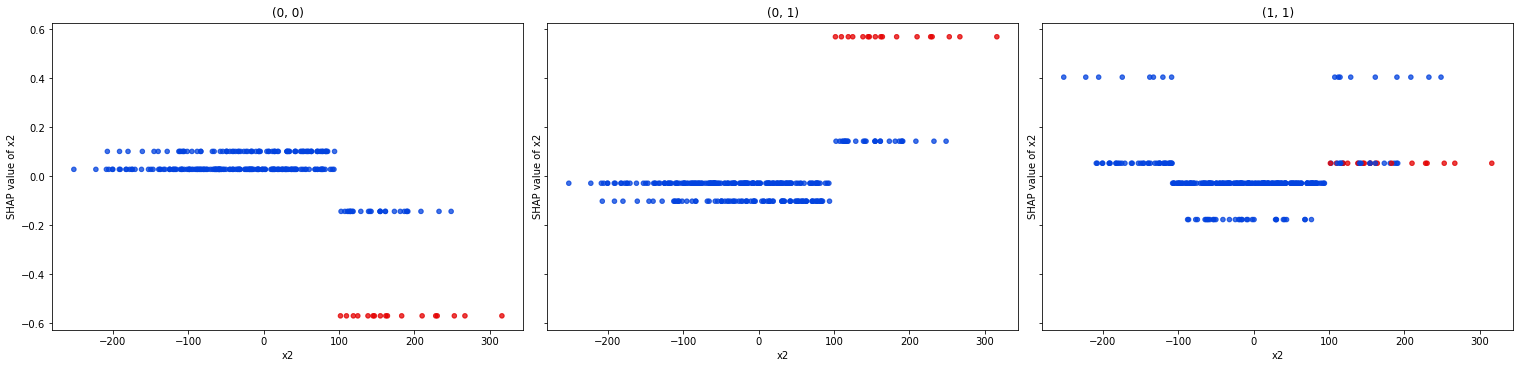

In [19]:
for feature in global_feature_order:
    node.plot_feature(feature, alpha=0.5)

In [25]:
node.describe_feature('x1')

,global,local-all,local-diff
count,600.000000,600.000000,34.000000
mean,-2.920353,-2.920353,-166.755088
std,187.847698,187.847698,31.750327
min,-293.394649,-293.394649,-199.699165
25%,-183.444208,-183.444208,-194.312742
50%,-8.544833,-8.544833,-171.292900
75%,174.936232,174.936232,-155.854926
max,437.353481,437.353481,-71.253414


In [26]:
node.describe_feature('x2')

,global,local-all,local-diff
count,600.000000,600.000000,34.000000
mean,-3.233006,-3.233006,179.696581
std,101.166569,101.166569,60.427552
min,-251.957930,-251.957930,101.871705
25%,-74.866120,-74.866120,138.378103
50%,-6.890370,-6.890370,162.109298
75%,60.078319,60.078319,228.253964
max,316.096597,316.096597,316.096597


### Node R

In [27]:
node = node.get_right()

R
(0, 0)    266
(0, 1)     34
dtype: int64


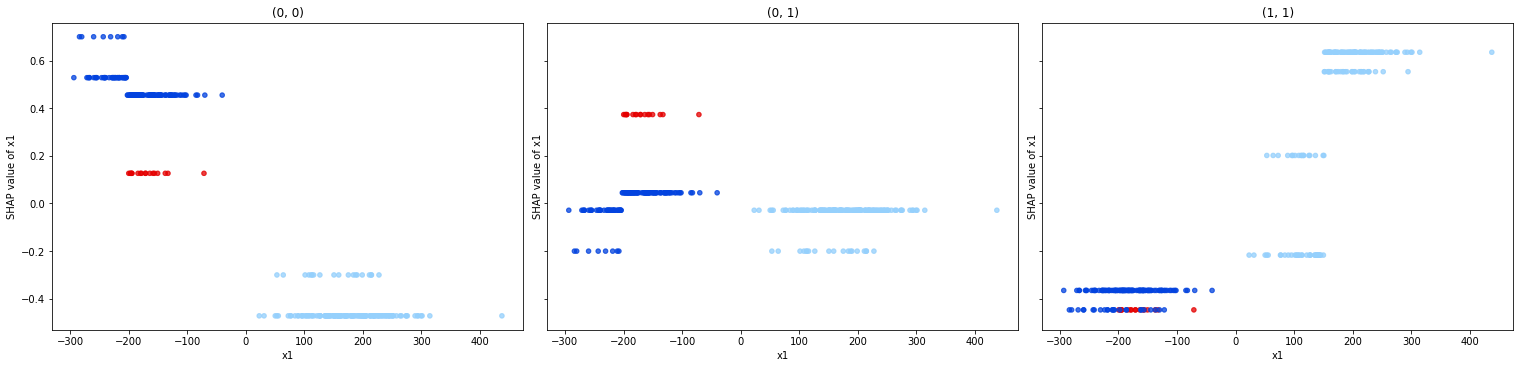

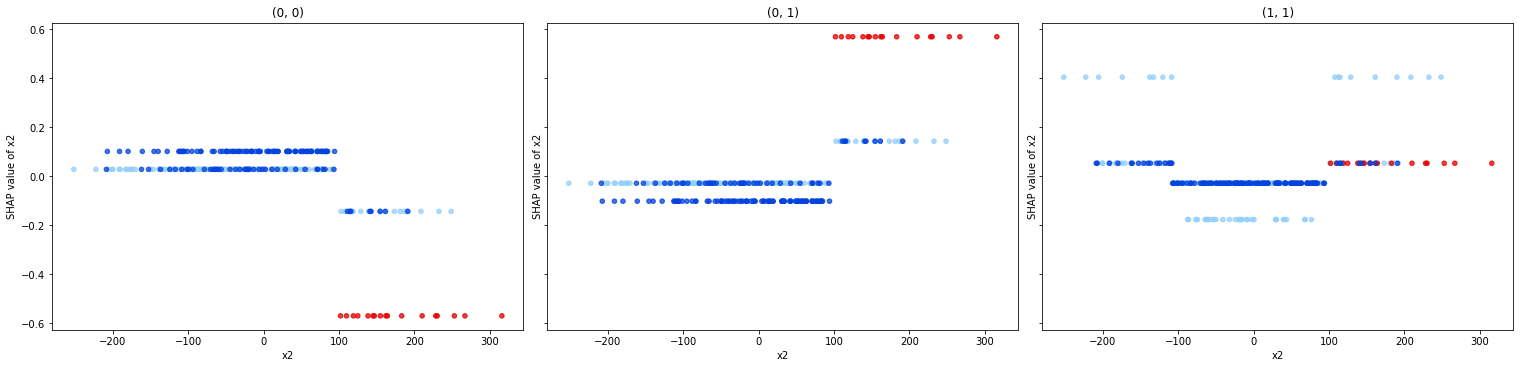

In [23]:
for feature in global_feature_order:
    node.parent.plot_feature(feature, focus=node, alpha=0.5)

In [28]:
node.describe_feature('x1')

,global,local-all,local-diff
count,600.000000,300.000000,34.000000
mean,-2.920353,-182.236320,-166.755088
std,187.847698,46.109800,31.750327
min,-293.394649,-293.394649,-199.699165
25%,-183.444208,-210.667827,-194.312742
50%,-8.544833,-183.595936,-171.292900
75%,174.936232,-154.772291,-155.854926
max,437.353481,-40.156930,-71.253414


In [36]:
node.test(x1=-8)

,before,after
"(0, 1)",34.0,NaN
"(1, 1)",NaN,34.0


### Node RL

In [39]:
node = node.get_left()

RL
(0, 1)    34
dtype: int64


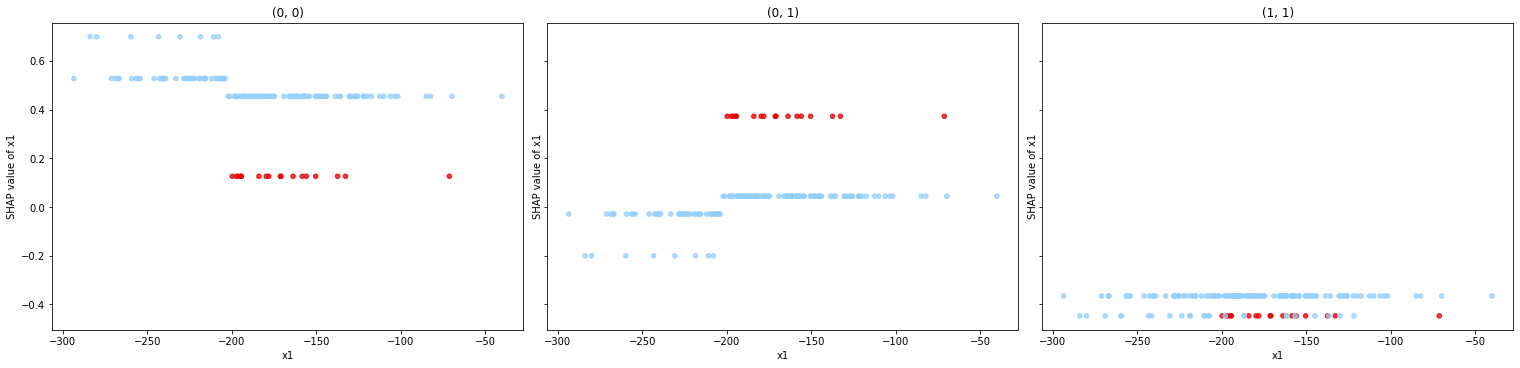

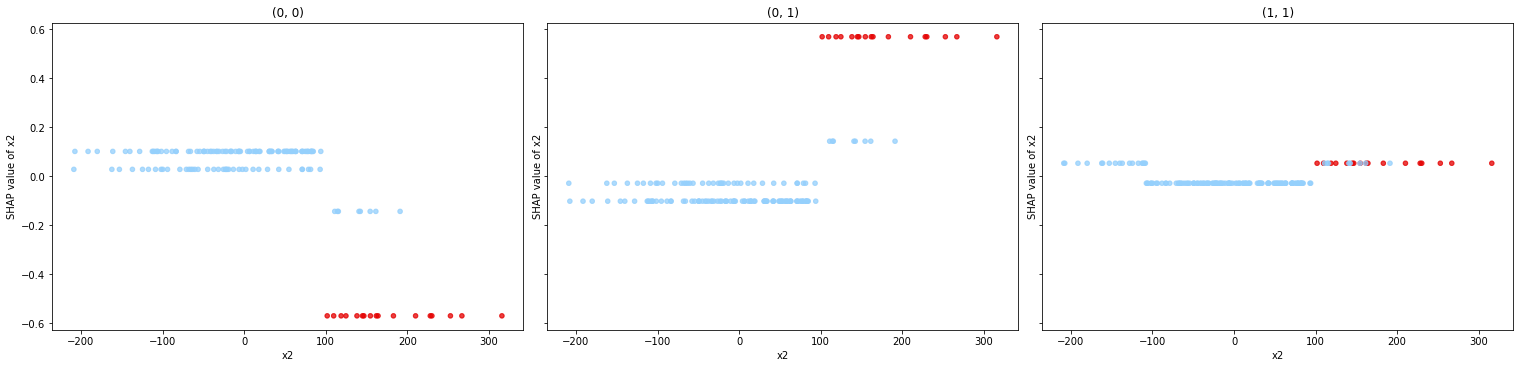

In [40]:
for feature in global_feature_order:
    node.parent.plot_feature(feature, focus=node, alpha=0.5)

In [46]:
node.describe_feature('x1')

,global,local-all,local-diff
count,600.000000,34.000000,34.000000
mean,-2.920353,-166.755088,-166.755088
std,187.847698,31.750327,31.750327
min,-293.394649,-199.699165,-199.699165
25%,-183.444208,-194.312742,-194.312742
50%,-8.544833,-171.292900,-171.292900
75%,174.936232,-155.854926,-155.854926
max,437.353481,-71.253414,-71.253414


In [47]:
node.describe_feature('x2')

,global,local-all,local-diff
count,600.000000,34.000000,34.000000
mean,-3.233006,179.696581,179.696581
std,101.166569,60.427552,60.427552
min,-251.957930,101.871705,101.871705
25%,-74.866120,138.378103,138.378103
50%,-6.890370,162.109298,162.109298
75%,60.078319,228.253964,228.253964
max,316.096597,316.096597,316.096597


In [45]:
node.test(x1=-204)

,before,after
"(0, 0)",NaN,34.0
"(0, 1)",34.0,NaN


In [52]:
node.test(x2=97)

,before,after
"(0, 0)",NaN,34.0
"(0, 1)",34.0,NaN


## Clustering of Class $(1,0)$ SHAP Values

In [53]:
node, Z = make_clustering(comparer, explanations.mclass_diff.labels, '(1, 0)', ['(0, 0)', '(1, 0)', '(1, 1)'])

root
(0, 0)    266
(1, 1)    236
(1, 0)     64
(0, 1)     34
dtype: int64


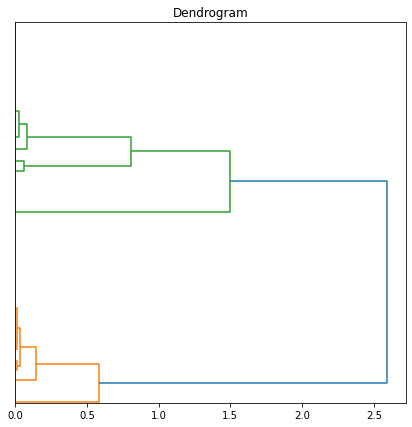

In [54]:
plot_dendrogram(Z)

### Root Node

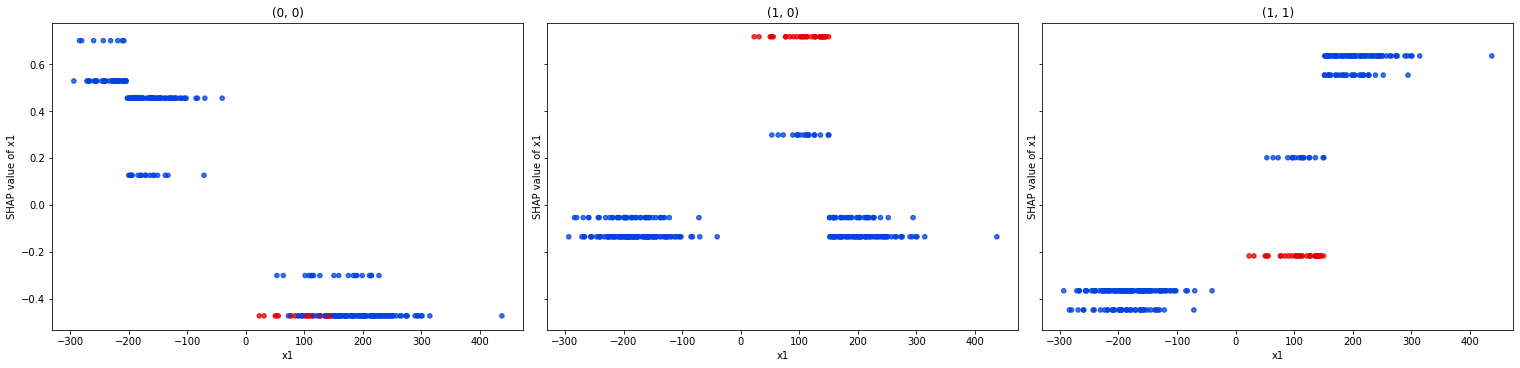

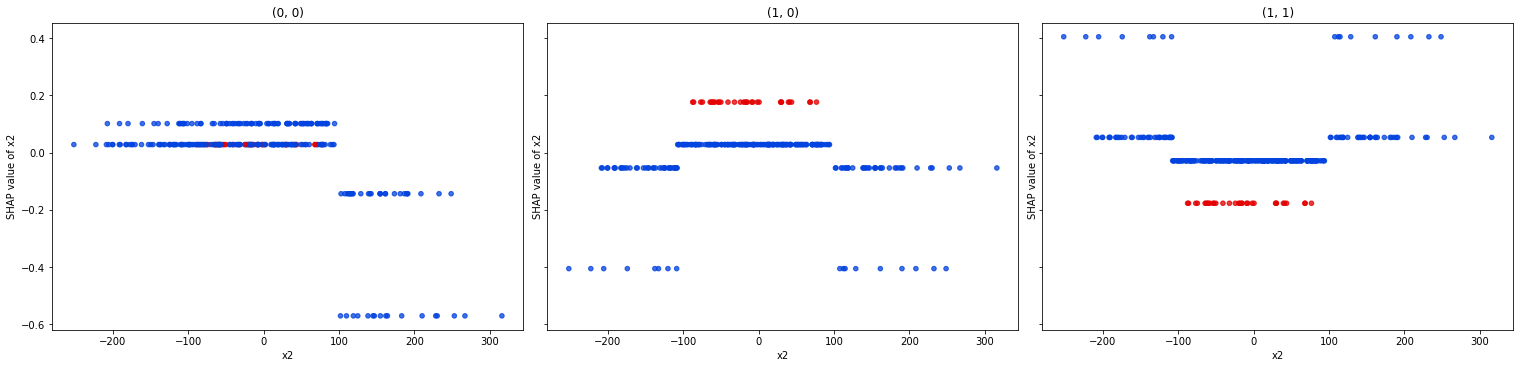

In [55]:
for feature in global_feature_order:
    node.plot_feature(feature, alpha=0.5)

In [56]:
node.describe_feature('x1')

,global,local-all,local-diff
count,600.000000,600.000000,64.000000
mean,-2.920353,-2.920353,107.604129
std,187.847698,187.847698,35.069628
min,-293.394649,-293.394649,23.067264
25%,-183.444208,-183.444208,88.511143
50%,-8.544833,-8.544833,113.224582
75%,174.936232,174.936232,137.889674
max,437.353481,437.353481,149.935488


In [57]:
node.describe_feature('x2')

,global,local-all,local-diff
count,600.000000,600.000000,64.000000
mean,-3.233006,-3.233006,-17.055967
std,101.166569,101.166569,47.776126
min,-251.957930,-251.957930,-87.589637
25%,-74.866120,-74.866120,-58.541738
50%,-6.890370,-6.890370,-18.991429
75%,60.078319,60.078319,29.322817
max,316.096597,316.096597,76.762508


### Node R

In [60]:
node = node.get_right()

R
(1, 1)    236
(1, 0)     64
dtype: int64


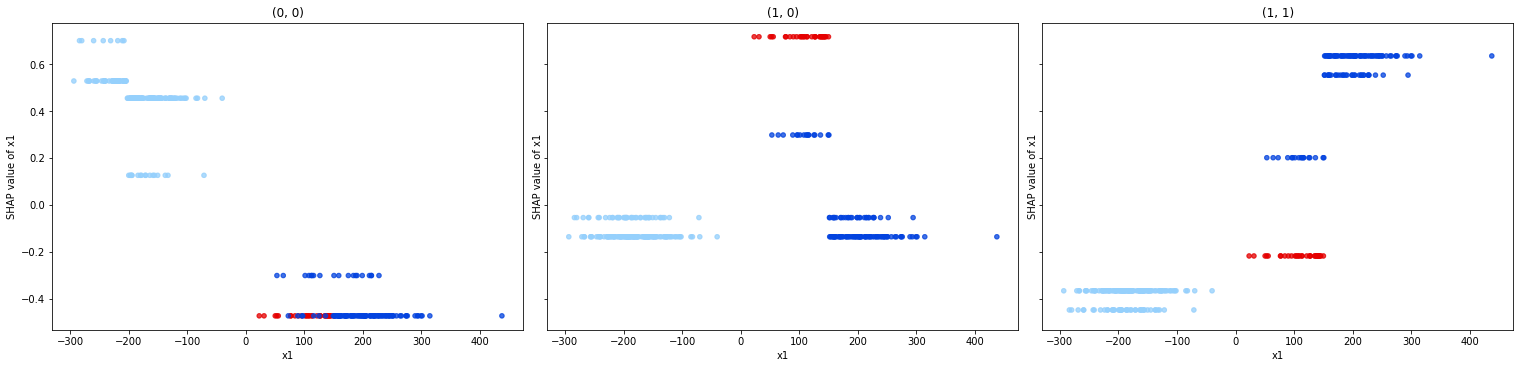

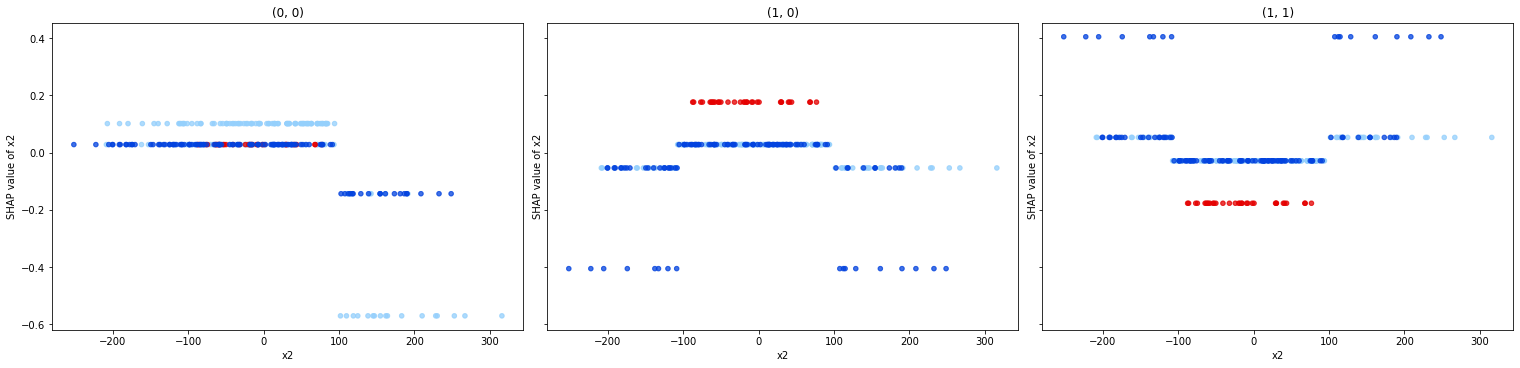

In [61]:
for feature in global_feature_order:
    node.parent.plot_feature(feature, focus=node, alpha=0.5)

In [62]:
node.describe_feature('x1')

,global,local-all,local-diff
count,600.000000,300.000000,64.000000
mean,-2.920353,176.395614,107.604129
std,187.847698,63.575995,35.069628
min,-293.394649,23.067264,23.067264
25%,-183.444208,136.269122,88.511143
50%,-8.544833,175.024014,113.224582
75%,174.936232,217.676751,137.889674
max,437.353481,437.353481,149.935488


In [65]:
node.test(x1=-9)

,before,after
"(0, 0)",NaN,64.0
"(1, 0)",64.0,NaN


### Node RL

In [67]:
node = node.get_left()

RL
(1, 0)    64
dtype: int64


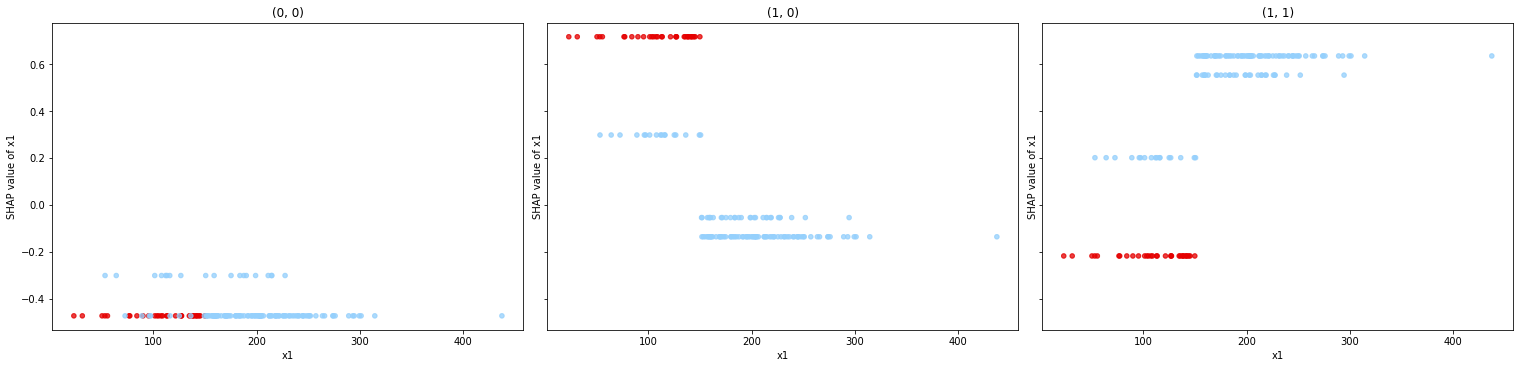

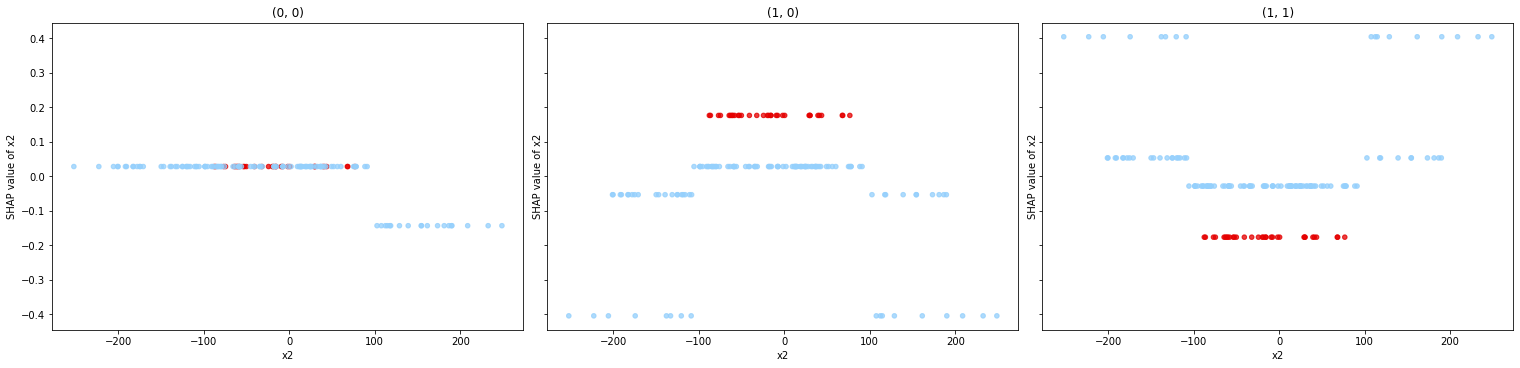

In [68]:
for feature in global_feature_order:
    node.parent.plot_feature(feature, focus=node, alpha=0.5)

In [69]:
node.describe_feature('x1')

,global,local-all,local-diff
count,600.000000,64.000000,64.000000
mean,-2.920353,107.604129,107.604129
std,187.847698,35.069628,35.069628
min,-293.394649,23.067264,23.067264
25%,-183.444208,88.511143,88.511143
50%,-8.544833,113.224582,113.224582
75%,174.936232,137.889674,137.889674
max,437.353481,149.935488,149.935488


In [70]:
node.describe_feature('x2')

,global,local-all,local-diff
count,600.000000,64.000000,64.000000
mean,-3.233006,-17.055967,-17.055967
std,101.166569,47.776126,47.776126
min,-251.957930,-87.589637,-87.589637
25%,-74.866120,-58.541738,-58.541738
50%,-6.890370,-18.991429,-18.991429
75%,60.078319,29.322817,29.322817
max,316.096597,76.762508,76.762508


In [72]:
node.test(x1=151)

,before,after
"(1, 0)",64.0,NaN
"(1, 1)",NaN,64.0


In [73]:
node.test(x2=-109)

,before,after
"(1, 0)",64.0,NaN
"(1, 1)",NaN,64.0


In [74]:
node.test(x2=98)

,before,after
"(1, 0)",64.0,NaN
"(1, 1)",NaN,64.0
